# User Interaction with our Model
This Notebook a simple pipeline, chaining our submodels and allowing users to interact with our model. The user should be allowed to type in his idea and then get a response including the following information:

1. Listing and Information about similar Businesses
2. A Stock market prediction
3. A success score and how it will perform compared to its competitors (ranking + score)

## Important notes
The following parameters must be kept the same, otherwise the training wont have much effect on the outcome.
- The PredictionModel.forward() method has the param **retrieval_number**, which must be set to **10**.
- The PredictionModel has the param **forecaset_steps** which must be set to **12**, to align with the ranking models inputs.

In [11]:
from RetrievalSystem.RetrievalSystem import RetrievalSystem
from PredictionModel.RetrievalAugmentedPredictionModel import RetrievalAugmentedPredictionModel
from RankingSystem.RankingModel import RankingModel
import pandas as pd
from transformers import BertTokenizer
import os
import torch
import matplotlib.pyplot as plt
import joblib

IDEA_IDENTIFIER = "NEW_IDEA"

class UserInterface:
    def __init__(self):
        self.max_length = 512

        self.dataset_path = "Dataset/Data/normalized_real_company_stock_dataset_large.csv"
        self.embeddings_path = "RetrievalSystem/Embeddings/embeddings.csv"

        self.rap_model_weights_path = "non_existent"
        self.ranking_model_weights_path = "non_existent"

        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=False)

        self.dataset = pd.read_csv(self.dataset_path)
        self.retrieval_model = RetrievalSystem(self.embeddings_path, 10)

        self.historical_scaler_path = "Dataset/Data/Scaler/historical_scaler_24.pkl"

        self.prediction_model = RetrievalAugmentedPredictionModel(ret_sys=self.retrieval_model, retrieval_number=10, forecast_steps=24)
        if os.path.exists(self.rap_model_weights_path):
            self.prediction_model.load_weights(self.rap_model_weights_path)

        self.ranking_model = RankingModel()
        if os.path.exists(self.ranking_model_weights_path):
            self.ranking_model.load_weights(self.ranking_model_weights_path)

    def tokenize(self, idea):
        inputs = self.tokenizer.encode_plus(
            idea,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']

        return input_ids, attention_mask

    def predict(self, text: str, retrieval_number: int = 10):
        if not text:
            raise ValueError("Please provide some text")

        # Retrieval
        retrieval_result = self.retrieval_model.find_similar_entries_for_batch(texts=[text], top_n=retrieval_number)
        idea_embedding, documents_identifier = retrieval_result[0]
        tickers = documents_identifier["tickers"].values

        documents = self.dataset.copy()
        documents = documents[documents["tickers"].isin(tickers)]

        # Prediction
        prediction = self.prediction_model(
            retrieval_result=retrieval_result,
            dataset=self.dataset,
            use_auxiliary_inputs=False
        )

        if os.path.exists(self.historical_scaler_path):
            with open(self.historical_scaler_path, "rb") as f:
                historical_scaler = joblib.load(f)
                print("Prediction before denormalization: ", prediction)
                prediction_numpy = prediction.detach().cpu().numpy()
                denormalized_prediction = historical_scaler.inverse_transform(prediction_numpy)
                prediction = torch.tensor(denormalized_prediction, dtype=prediction.dtype, device=prediction.device)
        else:
            raise FileNotFoundError("Historical Scaler not found")

        # Ranking
        month_columns = [col for col in self.dataset.columns if col.startswith("month")]
        ratings = {}

        input_ids, attention_mask = self.tokenize(text)
        ratings[IDEA_IDENTIFIER] = self.ranking_model(input_ids=input_ids, attention_mask=attention_mask, stock_performance=prediction)

        # Ratings for similar companies
        competitors = []
        for ticker in tickers:
            document = documents[documents["tickers"] == ticker]
            stock_performance = document[month_columns].iloc[:, -24:]
            stock_performance_tensor = torch.tensor(stock_performance.values, dtype=torch.float32)
            input_ids, attention_mask = self.tokenize(idea=document["business_description"].values[0])

            # Add to ratings
            ratings[ticker] = self.ranking_model(input_ids=input_ids, attention_mask=attention_mask, stock_performance=stock_performance_tensor)

            # Collect competitor info
            competitors.append({
                "ticker": ticker,
                "business_description": document["business_description"].values[0],
                "rating": ratings[ticker].item()
            })

        # Unified output
        result = {
            "retrieved_documents": documents.to_dict(orient="records"),
            "prediction": prediction[0].tolist(),
            "ratings": {
                "new_idea": ratings[IDEA_IDENTIFIER].item(),
                "competitors": competitors
            }
        }

        return result


    def visualize_results(self, result):
        # Extract data from the result
        retrieved_documents = result["retrieved_documents"]
        prediction = result["prediction"]
        ratings = result["ratings"]

        # Preview retrieved documents with a short description
        print("Retrieved Documents Preview:")
        for doc in retrieved_documents:
            print(f"- {doc['tickers']}: {doc['business_description'][:50]}...")

        # Prepare data for plotting
        month_columns = [col for col in self.dataset.columns if col.startswith("month")]

        # Plot each company's performance
        plt.figure(figsize=(12, 6))
        for doc in retrieved_documents:
            ticker = doc["tickers"]
            month_data = [doc[col] for col in month_columns if col in doc]
            plt.plot(month_data, label=ticker)
        plt.title("Performance of Retrieved Companies")
        plt.xlabel("Months")
        plt.ylabel("Performance")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot the predicted idea performance
        plt.figure(figsize=(8, 4))
        plt.plot(prediction, label="New Idea", color="red")
        plt.title("Predicted Performance of New Idea")
        plt.xlabel("Months")
        plt.ylabel("Performance")
        plt.grid(True)
        plt.legend()
        plt.show()

        # List companies sorted by rank
        print("\nCompanies Ranked by Rating:")
        ranked_companies = sorted(ratings["competitors"], key=lambda x: x["rating"], reverse=True)
        for idx, company in enumerate(ranked_companies, start=1):
            print(f"{idx}. {company['ticker']} - Rating: {company['rating']:.4f}")




# Main
Here we can now test our UserInterface

Retrieved tickers:  [array(['BBW', 'MAT', 'SRM', 'JAKK', 'MNSO', 'TGT', 'MTEN', 'TTSH', 'FEBO',
       'AZEK'], dtype=object)]
We have these retrieved documents:  torch.Size([1, 10, 106])
Shapes: month_data: (10, 72), static_data: (10, 34)
Static Tensor Shape: torch.Size([1, 340]), Historical Tensor Shape: torch.Size([1, 720])
Shape of weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10, 1])
Shape of static_output: torch.Size([1, 128]), similarity: torch.Size([1, 10]), historical: torch.Size([1, 256])
Shapes: weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10]), combined_static_output: torch.Size([1, 128]), combined_historical: torch.Size([1, 256]), similarity: torch.Size([1, 10])
Shape of combined_retrieval_input: torch.Size([1, 788])
Shapes of static_output: torch.Size([1, 16]), historical_output: torch.Size([1, 32]), idea: torch.Size([1, 128]), attention_output: torch.Size([1, 384])
Shapes of static_output: torch.Size([1, 16]), historical_o

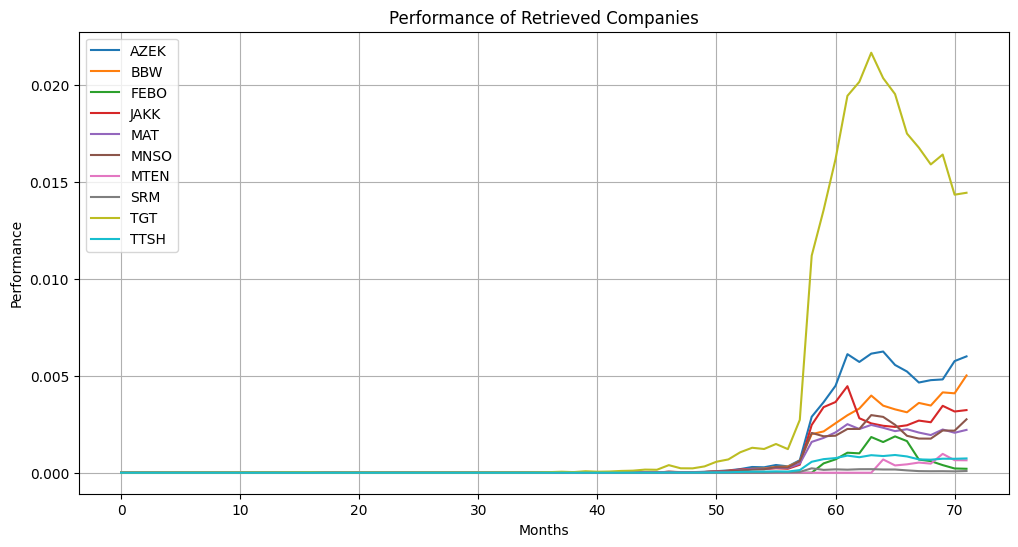

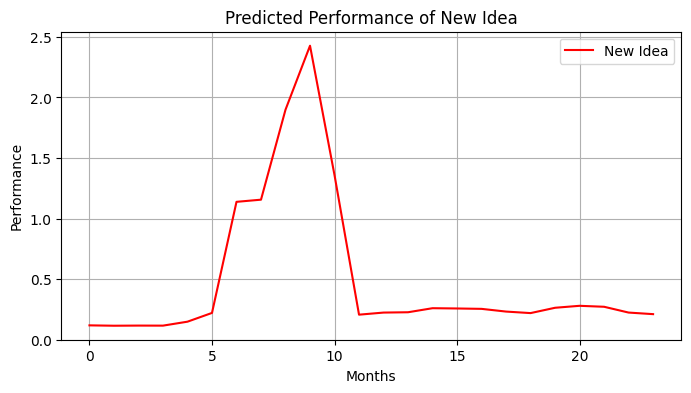


Companies Ranked by Rating:
1. SRM - Rating: -0.0503
2. AZEK - Rating: -0.0526
3. FEBO - Rating: -0.0552
4. MAT - Rating: -0.0579
5. JAKK - Rating: -0.0631
6. MNSO - Rating: -0.0671
7. MTEN - Rating: -0.0689
8. BBW - Rating: -0.0701
9. TTSH - Rating: -0.0779
10. TGT - Rating: -0.0786


In [12]:
if __name__ == "__main__":
    idea = "I want to build a stockprediction model that can be used to predict stock performance for potential business idea. This should help to gather first insights into the potential of an idea. Additionally it should lookup similar companies so that on overview over competitors is given. It should also rate the new idea based on the predicted stock performance and rank them among its competitors."

    idea = "Lego Shop"

    userinterface = UserInterface()
    response = userinterface.predict(idea)
    userinterface.visualize_results(response)

    # print(response)